# Homework 4: Conversation Modeling and decoding

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [0]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!

In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [0]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [7]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

--2019-11-12 01:34:27--  https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 01:34:28--  https://nyu.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 01:34:28--  https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!-iiF2wevgy6gx2

100%|██████████| 7801/7801 [00:00<00:00, 12734.93it/s]


In [8]:
print(train_dataset[0])
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

(tensor([   7,   10,   12,    5,   21,   14, 3583, 1607,    4,   11,    7,   10,
          12,    5,   21,   14,   56,  655,    4,   11,    7,   10,   12,    5,
          21,   14, 1806,    8, 2105,    4,   11,    7,   10,   12,   15,   44,
        1255,   18,  862,    4,   11,   58,   13,   34,   25,    6,   65,    9,
           5,   16,   26,  245,  430,   14,   17,   97, 6377, 2587,   14,  286,
          24, 1145,    4]), tensor([  6, 252,  46,  83, 351,   4, 655,  18,  79,  30,  15,  44, 171,   4,
          2]))


In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [10]:
current_device = 'cuda'
model_pt = torch.load('./chat_model_best_22.pt')
opts = model_pt['opts']    
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
  )
)

In [11]:
len(chat_dict)

18760

In [0]:
import torch.nn.functional as F
def nucleus_sampling(logits,p=0.0,filter_value=-float('Inf')):
  # https://medium.com/huggingface/how-to-build-a-state-of-the-art-conversational-ai-with-transfer-learning-2d818ac26313
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    # Remove tokens with cumulative probability above the threshold
    sorted_indices_to_remove = cumulative_probs > p
    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
    sorted_indices_to_remove[0] = 0

    indices_to_remove = sorted_indices[sorted_indices_to_remove]
    logits[indices_to_remove] = filter_value
    return logits


In [13]:
for i, batch in enumerate(valid_loader):
    model.eval()
    text_vecs = batch['text_vecs'].to('cuda')
    target_vecs = batch['target_vecs'].to('cuda')
    text_lens = batch['text_lens']
    print(text_vecs.shape)
    break

torch.Size([256, 332])


In [0]:
import numpy as np
def greedy_search(model, batch, batch_size,p):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)

    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts.view(-1)]
    scores = []
    log_prob = 0.0
    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    _attn_w_log = []
    log_history = []
    unique_tokens = []
    for i in range(100):
      for ts in range(100):
          decoder_output, decoder_hidden, attn_w_log = model.decoder(xs.view(1,-1), decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
          temp = F.softmax(decoder_output.view(-1),dim=-1)
          logits = nucleus_sampling(decoder_output.view(-1),p=p)
          prob_dist = F.softmax(logits,dim=-1)
          _preds = torch.multinomial(prob_dist,1)
          if _preds.item() not in unique_tokens:
            unique_tokens.append(_preds.item())
          _scores = temp[_preds.item()]
          log_prob += np.log(_scores.item())
          preds.append(_preds)
          _attn_w_log.append(attn_w_log)
          scores.append(_scores.view(-1)*(finish_mask == 0).float())

          finish_mask += (_preds == 2).byte().view(-1)
          if not (torch.any(~finish_mask.bool())):
              log_history.append(log_prob)
              break
          
          xs = _preds
    preds = torch.cat(preds, dim=-1)
    preds = preds[1:-1]    
    return scores, preds, log_prob, np.mean(log_history),unique_tokens

In [62]:
inputs = RETOK.findall(chat_dict.v2t(valid_dataset[0][0].tolist()))

test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
}

print(" ".join(inputs),"\n")
scores, output, log_prob, avg_log, num_tokens = greedy_search(model, test_batch, 1,0.5)

print(chat_dict.v2t(output.tolist()),"\n")
print("log_prob:",log_prob)

your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 

i am just hanging out with my girlfriend and i love animals __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __end__ __e

In [0]:
ps = [0.1,0.5,0.9]
log_probs = []
num_tokens = []

for p in ps:
  inputs = RETOK.findall(chat_dict.v2t(valid_dataset[0][0].tolist()))

  test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
}

  scores, output, log_prob, avg_log, unique_tokens = greedy_search(model, test_batch, 1,p)
  log_probs.append(avg_log)
  num_tokens.append(len(unique_tokens))

## You present here:

Text(0.5, 1.0, 'Avg log probs')

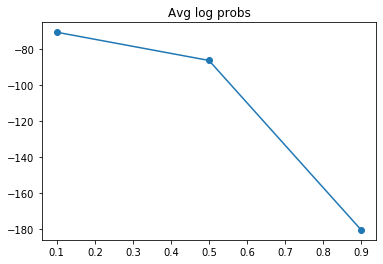

In [68]:
# check pdf to see what you expected to present
import matplotlib.pyplot as plt
plt.plot(ps,log_probs,"-o")
plt.title("Avg log probs")

Text(0.5, 1.0, 'number of unique tokens')

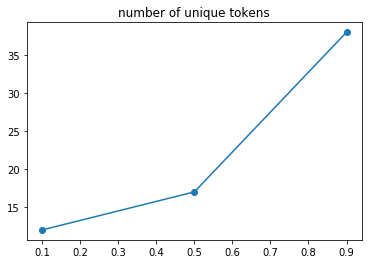

In [69]:
plt.plot(ps,num_tokens,"-o")
plt.title("number of unique tokens")